In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from PIL import Image
from pylab import rcParams
from typing import cast, Any, Union, Dict, List
import time
import random
import copy
import pandas as pd

import matplotlib.pyplot as plt

import os
import shutil
from collections import OrderedDict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(64, num_classes)
          )

      if init_weights:
        self.initialize_weights()

  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

cfgs: Dict[str, List[Union[int, str]]] = {
    'A': [64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'firstPadding':2
}

def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Module] = []
  in_channels = 1
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model

## Define Model

In [3]:
model_path = './ModelsSave'
model_name = 'model=2022-11-17_19-14-53-0.7448.pth'

model = selfDefineVgg(cfgs, 'A', True, 11)
model = model.to(device)

state_dict = torch.load(model_path+'/'+model_name)
model.load_state_dict(state_dict=state_dict)


<All keys matched successfully>

In [4]:
import torchvision.transforms.functional as F
from PIL import ImageStat

# Show Function for image tensor
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def is_grayscale(path):
    im = Image.open(path).convert("RGB")
    stat = ImageStat.Stat(im)
    if sum(stat.sum)/3 == stat.sum[0]: #check the avg with any element value
        return True #if grayscale
    else:
        return False #else its colour

def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)
    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

In [5]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from rembg import remove
# from google.colab.patches import cv2_imshow

def pre_image(image_path,model):
   transform_norm_grayscale = transforms.Compose([
       transforms.Resize((50,50)),
       transforms.ToTensor()
       ])
   transform_norm_rgb = transforms.Compose([
       transforms.Grayscale(),
       transforms.Resize((50,50)),
       transforms.RandomInvert(p=1),
       transforms.ToTensor()
       ])

   ori = Image.open(image_path)
   width, height = ori.size   # Get dimensions
   if (width != height):
       base_ori = Image.new('RGB', (width, height), (255, 255, 255))
       output = remove(ori)
       base_ori.paste(output, (0,0), output)
       # Resize
       ori_r = resize_with_pad(im=base_ori, target_width=500, target_height=500)
       ori_r.save(f"./Jury_test/resResize/{image_path.split('/')[-1]}")
       img = ori_r.convert('L')
   else:
       img = Image.open(image_path).convert('L')

   # Read Image
   # img = Image.open(image_path).convert('L')
   # display(img)

   # Is Image Grayscale?
   if (is_grayscale(image_path)):
       print("Grayscale")
       img_normalized = transform_norm_grayscale(img).float()
       # show(img_normalized)
       img_normalized = img_normalized.unsqueeze_(0)
       img_normalized = img_normalized.to(device)
   else:
       print("RGB")
       img_normalized = transform_norm_rgb(img).float()
       # show(img_normalized)
       img_normalized = img_normalized.unsqueeze_(0)
       img_normalized = img_normalized.to(device)

   print("Shape Image:",img_normalized.shape)
   with torch.no_grad(): # Predict Image
      model.eval()
      output =model(img_normalized)
      index = output.data.cpu().numpy().argmax()
      classes = ["Ankle Bot", "Bag", "Coat", "Dress", "Hat", "Pullover", "Sandal", "Shirt", "Sneaker", "T-shirt/Top", "Trouser"]
      class_name = classes[index]
      return class_name

C:\Users\Overl\PycharmProjects\pythonProject\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# Test from local
# test_file_path = "./Jury_test/resResize/hat_4.jpg"
# predict_class = pre_image(test_file_path, model)
# print(predict_class)

## Submission

RGB
Shape Image: torch.Size([1, 1, 50, 50])


C:\Users\Overl\AppData\Local\Temp\ipykernel_4140\3053081086.py:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)


RGB
Shape Image: torch.Size([1, 1, 50, 50])
Grayscale
Shape Image: torch.Size([1, 1, 50, 50])
Grayscale
Shape Image: torch.Size([1, 1, 50, 50])
Grayscale
Shape Image: torch.Size([1, 1, 50, 50])
Grayscale
Shape Image: torch.Size([1, 1, 50, 50])
Grayscale
Shape Image: torch.Size([1, 1, 50, 50])
Grayscale
Shape Image: torch.Size([1, 1, 50, 50])
Grayscale
Shape Image: torch.Size([1, 1, 50, 50])
RGB
Shape Image: torch.Size([1, 1, 50, 50])
RGB
Shape Image: torch.Size([1, 1, 50, 50])
Akurasi Test: 90.9090909090909
                  Filename      Class Class Predict  result
0                hat_3.jpg        Hat           Hat    True
1                hat_4.jpg        Hat           Hat    True
2       mnist_11_shoes.png  Ankle Bot     Ankle Bot    True
3         mnist_35_bag.png        Bag           Bag    True
4             mnist_41.png    Sneaker       Sneaker    True
5             mnist_58.png      Dress         Dress    True
6            mnist_112.png      Shirt      Pullover   False
7      

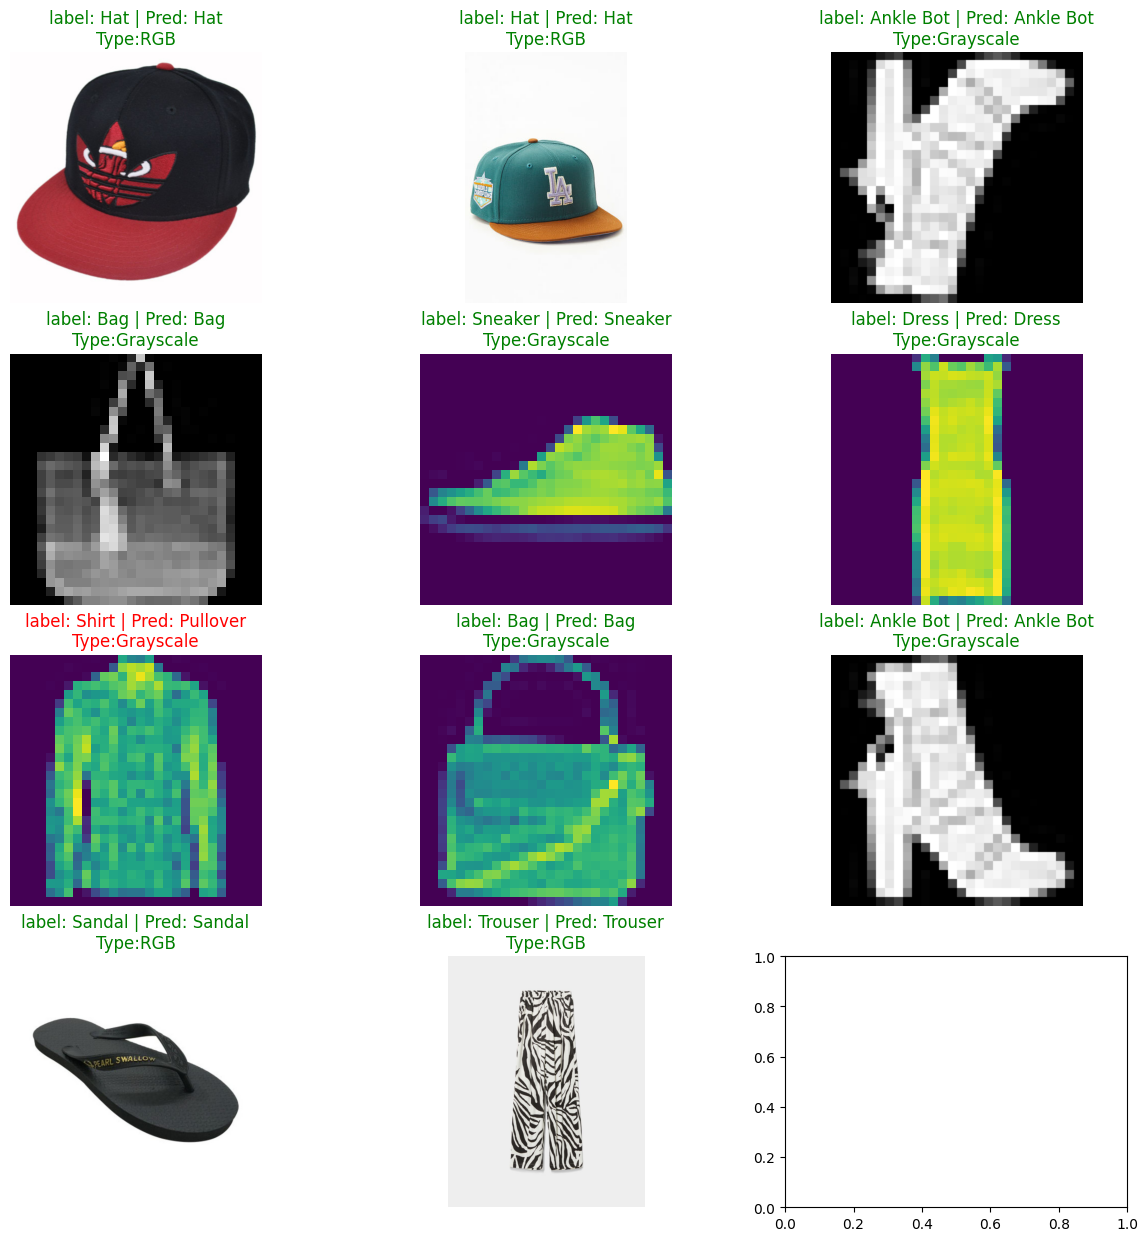

In [7]:
import pandas as pd

testing_path = './Jury_test'
submission_path = testing_path+'/submission.xlsx'

def evaluation(path, mdl):
    submission = pd.read_excel(path)
    Total = len(submission['Filename'].tolist())
    Correct = 0
    result = []
    for i in range(0, Total):
        result.append(False)
    submission.insert(len(submission.columns),"Class Predict",result, True)
    submission.insert(len(submission.columns),"result",result, True)

    fig, axes = plt.subplots((Total//2)-1, 3, figsize=(15, 15))

    n = 0
    for filename, ax in zip(submission['Filename'], axes.flatten()):
        predict_class = pre_image(testing_path+f'/{filename}', mdl)
        submission.at[n,'Class Predict']=predict_class

        img = Image.open(testing_path+'/'+filename)
        font = {"color": 'g'} if predict_class==submission['Class'][n] else {"color": 'r'}
        label, pred = submission['Class'][n], predict_class

        ax.imshow(img)
        ax.set_title(f"label: {label} | Pred: {pred}\nType:{'Grayscale' if is_grayscale(testing_path+'/'+filename) else 'RGB'}", fontdict=font)
        ax.axis('off')

        if (predict_class==submission['Class'][n]):
            submission.at[n,'result']=True
            Correct += 1
        n += 1

    print(f"Akurasi Test: {(Correct/Total) * 100}" )
    print(submission)

evaluation(path=submission_path, mdl=model)